In [6]:
import os
import sys
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.prompts import PromptTemplate

from langchain_core.retrievers import BaseRetriever
from typing import Dict, Any
from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

In [7]:
import os
from config import HF_TOKEN, open_ai_key
import warnings
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_huggingface  import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama

# Ignore all the warnings given by different packages
warnings.filterwarnings('ignore')

# Retrieve the open ai and hf tokens from the configuration file
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["OPENAI_API_KEY"] = open_ai_key

# Select the GPU as the device
model_kwargs = {'device': 'cuda'}

# Required for fast similarity computations
encode_kwargs = {'normalize_embeddings': True}

# Initialize Embeddings, GPT and Ollama Model
llm_gpt = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=open_ai_key)

llm_text = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = ''
)

llm_json = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = 'json'
)

model_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

In [8]:
from langchain.retrievers import BM25Retriever
from langchain.retrievers.ensemble import EnsembleRetriever

In [9]:
from langchain_community.document_loaders import PyMuPDFLoader
import os

pdf_folder_path = "./utils/data"
documents = []
for file in os.listdir(pdf_folder_path):
    if file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder_path, file)
        loader = PyMuPDFLoader(pdf_path)
        documents.extend(loader.load())
        
print(f"total documents loaded - {len(documents)}")

total documents loaded - 427


In [23]:
from langchain_experimental.text_splitter import SemanticChunker

# text_splitter = SemanticChunker(model_embeddings)
# chunked_documents_semantic  = text_splitter.split_documents(documents)

In [12]:
bm25_retriever = BM25Retriever.from_documents(chunked_documents_semantic)
bm25_retriever.k =  5

NameError: name 'chunked_documents_semantic' is not defined

In [13]:
from utils1 import *

vectorstore_semantic = create_or_load_vector_db(chunked_documents="", persist_directory=f"./vector_store_semantic", load=True)

vs_retriever = vectorstore_semantic.as_retriever()

In [14]:
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, vs_retriever],
                                       weights=[0.4, 0.6])

NameError: name 'bm25_retriever' is not defined

In [15]:
import time
import json

with open("test_data_30.json", "r") as file:
    cleaned_data = json.load(file)


In [31]:
class AnswerStructure(BaseModel):
    answer: str = Field(description="answer to the given question")

parser = JsonOutputParser(pydantic_object=AnswerStructure)

import time
def get_llm_response(query, vectordb, ensemble_retriever):
    # pull the prompt from HF hub
    prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Give a detailed answer to the question by reading the context
    \nQuestion: {question} \nContext: {context}
    Give answer in the below json format only. No deviations:
    {{
        "answer":str
    }}
    Your response must be strictly valid JSON with no additional text, markdown formatting, or commentary.
    Make sure to have the key with the name "answer"
    don't include any backticks like ``` or any text like ```json while starting the json
"""

    SYSTEM_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=prompt
)

    # create a chain with prompt and llama 3.2 1B llm
    rag_chain_from_docs = (
            RunnablePassthrough()
            | SYSTEM_PROMPT
            | llm_json
            | parser
        )

    temp = ensemble_retriever.get_relevant_documents(query)

    docs_content = {i: doc.page_content for i, doc in enumerate(temp)}

    try:
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    except Exception as e:
        print(str(e))
        time.sleep(5)
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    
    return result["answer"], list(docs_content.values())

In [32]:
import concurrent.futures
import tqdm

def process_llm_response(k, v, vectordb, retriever):
    """Function to fetch LLM response in parallel."""
    answer, context = get_llm_response(v["question"], vectordb, retriever)
    return k, {"question": v["question"], "answer": answer, "context":context}

def get_response(cleaned_data, vectordb, retriever):
    llm_response_data = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(process_llm_response, k, v, vectordb, retriever): k for k, v in cleaned_data.items()}
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            k, result = future.result()
            llm_response_data[k] = result
        return llm_response_data

In [33]:
import pandas as pd
from ragas import SingleTurnSample, EvaluationDataset
from ragas import evaluate
from ragas.run_config import RunConfig
import warnings
import random
import time

from ragas.metrics import LLMContextPrecisionWithReference, LLMContextRecall, ResponseRelevancy, Faithfulness

warnings.filterwarnings('ignore')
        
def save_evaluator_results(result, name):
    result.to_csv(f"evaluation_{name}.csv")

def evaluator(name, cleaned_data, vectordb, retriever):
    data_list = []
    
    # Get Response from the selected Vector DB
    llm_response_data = get_response(cleaned_data, vectordb, retriever)

    # Persist the response for later usage
    with open(f"llm_response_data_{name}.json", "w") as file:
        json.dump(llm_response_data, file, indent=4)

    # Create an evaluation dataset
    for k, v in llm_response_data.items():
        row = SingleTurnSample(
            user_input=v["question"],
            retrieved_contexts=v["context"],
            response=v["answer"],
            reference=cleaned_data[k]["answer"],
            reference_contexts = [cleaned_data[k]["answer"]]
        )
    
        data_list.append(row)
    dataset = EvaluationDataset(samples=data_list)
    

    # To make the evaluation faster, we will go with two metrics at a time
    result_1 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[LLMContextPrecisionWithReference(), LLMContextRecall()]).to_pandas()

    # Adding a sleep timer to avoid rate limit or token limit error
    time.sleep(30)
    
    result_2 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[ResponseRelevancy(), Faithfulness()]).to_pandas()

    # Merge all the metrics
    result = pd.merge(result_1, result_2[['user_input', 'answer_relevancy', 'faithfulness']], on='user_input')

    # Persist the metrics result for the experiment
    save_evaluator_results(result, name)
    
    return result

In [50]:
experiment_name = "semantic_default"
result = evaluator("hybrid_"+experiment_name, cleaned_data, vectorstore_semantic, ensemble_retriever)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:53<00:00,  1.12it/s]


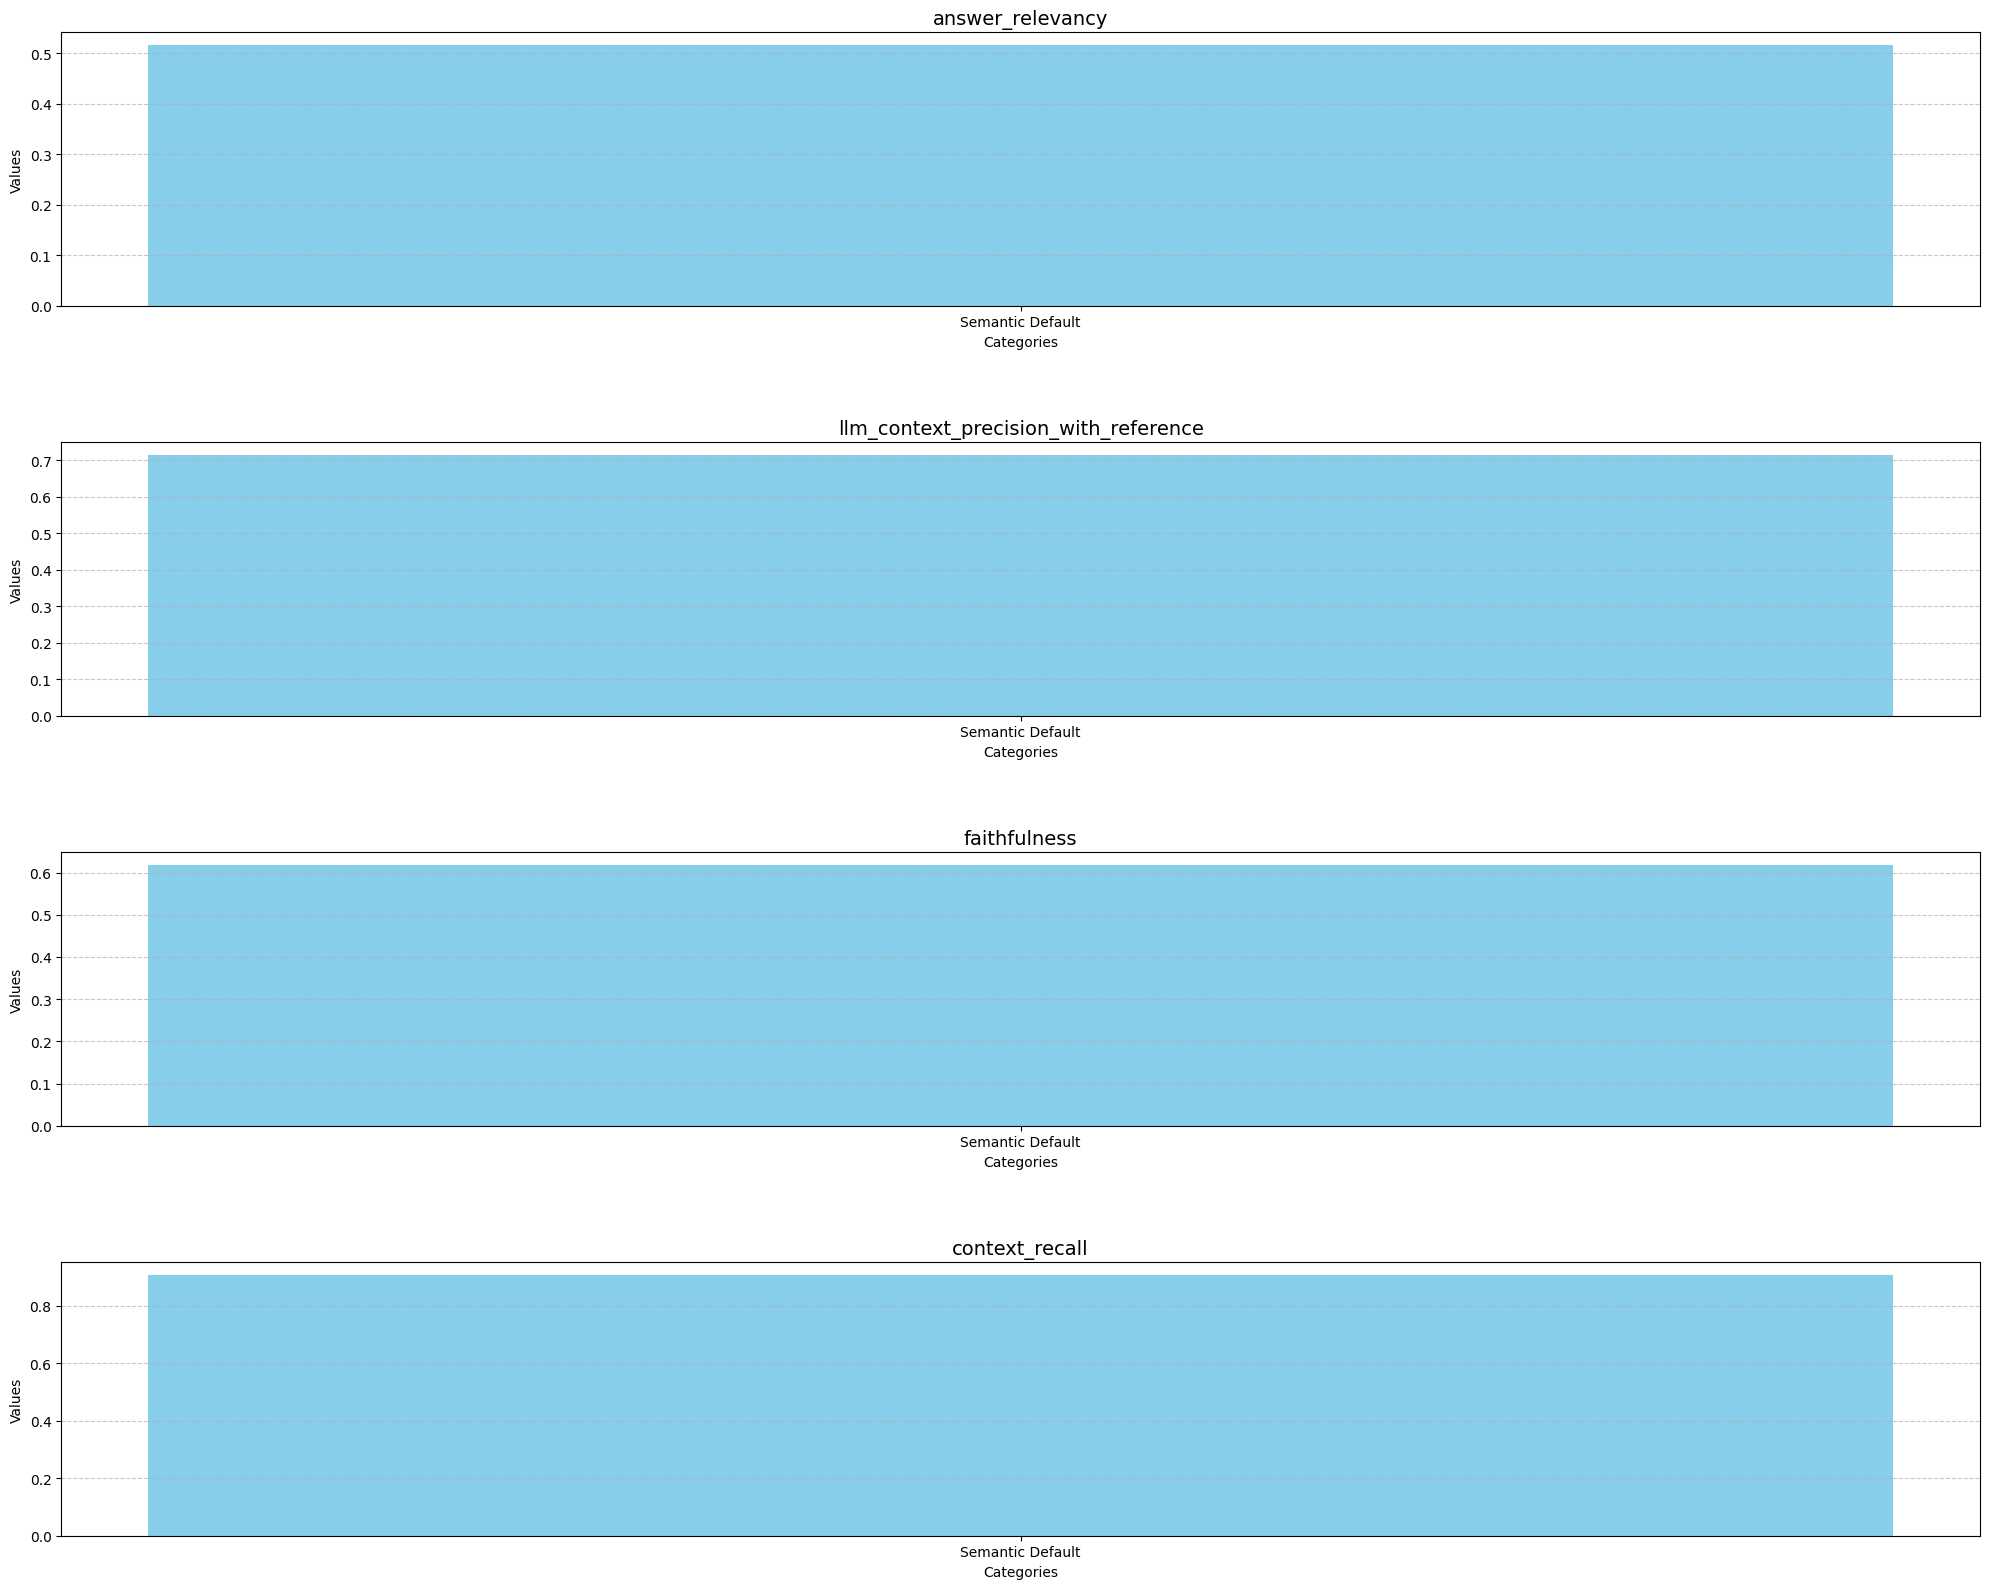

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Semantic Default"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(result[m], nan=0)),
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

# Multi Vector Retriever

In [18]:
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [19]:
from langchain.storage import InMemoryByteStore
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [37]:
text_splitter = SemanticChunker(model_embeddings, number_of_chunks=100)
docs = text_splitter.split_documents(documents)

In [38]:
vectorstore2 = Chroma(
    collection_name="full_documents", embedding_function=model_embeddings
)
# The storage layer for the parent documents
store2 = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever2 = MultiVectorRetriever(
    vectorstore=vectorstore2,
    byte_store=store2,
    id_key=id_key,
    embedding_function=model_embeddings
)
import uuid

doc_ids = [str(uuid.uuid4()) for _ in docs]

In [39]:
child_text_splitter = SemanticChunker(model_embeddings, number_of_chunks=50)

In [40]:
sub_docs = []
for i, doc in enumerate(docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

In [26]:
retriever2.vectorstore.add_documents(sub_docs)
retriever2.docstore.mset(list(zip(doc_ids, docs)))

In [35]:
experiment_name = "semantic_default"
result = evaluator("multi_vector"+experiment_name, cleaned_data, vectorstore_semantic, retriever2)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:39<00:00,  1.53it/s]


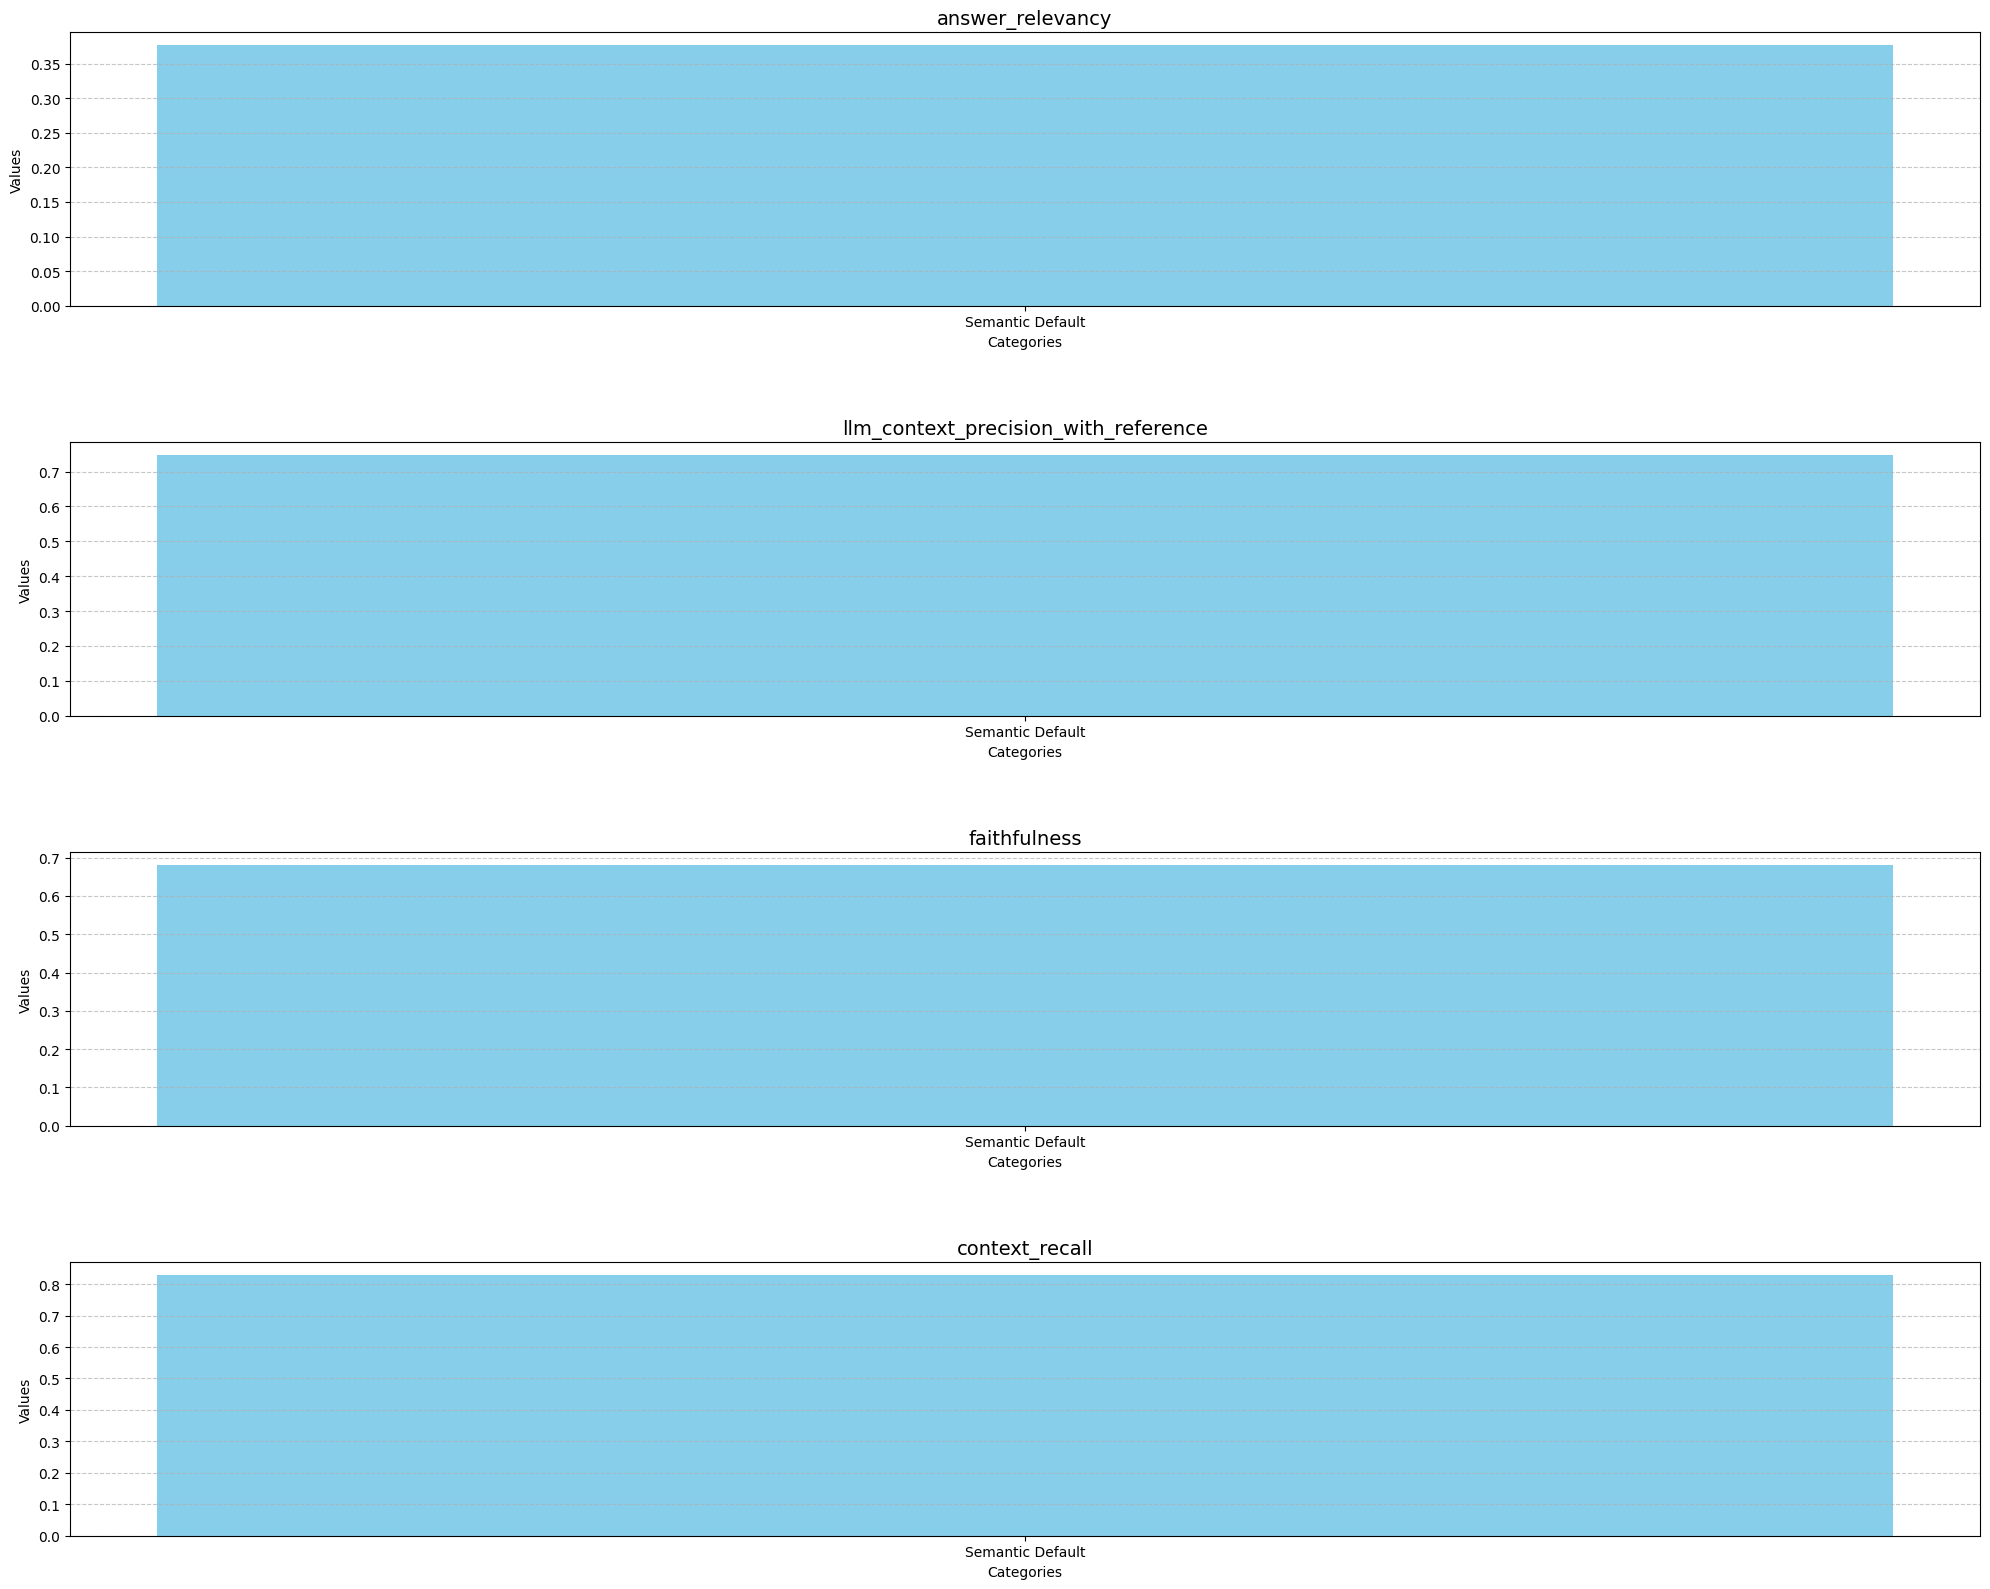

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Semantic Default"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(result[m], nan=0)),
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

# Parent Document Retriever

# Self Query Retriever

# Contextual Compression

# Multi Query Retriever